In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.2 MB/s 
     |████████████████████████████████| 831.4 MB 2.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn import metrics


# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
#my data
source_folder = '/content/drive/My Drive/DL/DL_Final_Project/source'
destination_folder = '/content/drive/My Drive/DL/DL_Final_Project/destination_lstm'

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# load dataset

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('class', label_field), ('text', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)  # Building vocabularies => (Token to integer)
#build the vocabulary using the train iterator (counting only the tokens with a minimum frequency of 3)

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
print("Size of text vocab:",len(text_field.vocab))
print(vars(train.examples[23]))

Size of text vocab: 34260
{'class': '0', 'text': ['tough', 'critique', 'dennis', 'lehane', 'he', 's', 'master', 'craft', 'particularly', 'style', 'writing', 'streamlined', 'prose', 'reminds', 'reading', 'script', 'novel', 'though', 'bad', 'way', 'add', 'story', 'gangsters', 'world', 'passing', 'recipe', 'great', 'novel', 'highlights', 'least', 'inner', 'workings', 'understanding', 'mobsters', 'moved', 'illegal', 'operations', 'legitimate', 'business', 'part', 'seeing', 'economy', 'built', 'illegal', 'activity', 'love', 'idea', 'miss', 'thrill', 'breaking', 'law', 'legitimizing', 'operations', 'recently', 'reading', 'godfather', 'however', 'say', 'one', 'trumps', 'novel', 'long', 'shot', 'still', 'pleasant', 'easy', 'read', 'great', 'characters', 'something', 'that', 's', 'going', 'revolutionize', 'particular', 'genre']}


In [ ]:
# building the model
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)    # Dense layer to predict 

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        # Thanks to packing, LSTM don't see padding tokens 
        # and this makes our model better
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        # Concatenating the final forward and backward hidden states
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        #Final activation function
        text_out = torch.sigmoid(text_fea)

        return text_out

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [ ]:
# Training Function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)),_ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)  
            
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')




In [ ]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)    #0.001

In [ ]:
%%time
train(model=model, optimizer=optimizer, num_epochs=8)

Epoch [1/8], Step [175/2808], Train Loss: 0.6461, Valid Loss: 0.7191
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination_lstm/model.pt
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination_lstm/metrics.pt
Epoch [1/8], Step [350/2808], Train Loss: 0.6153, Valid Loss: 0.8312
Epoch [2/8], Step [525/2808], Train Loss: 0.6328, Valid Loss: 0.7095
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination_lstm/model.pt
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination_lstm/metrics.pt
Epoch [2/8], Step [700/2808], Train Loss: 0.5626, Valid Loss: 0.9606
Epoch [3/8], Step [875/2808], Train Loss: 0.5904, Valid Loss: 0.7160
Epoch [3/8], Step [1050/2808], Train Loss: 0.4637, Valid Loss: 0.9746
Epoch [4/8], Step [1225/2808], Train Loss: 0.5218, Valid Loss: 0.7349
Epoch [4/8], Step [1400/2808], Train Loss: 0.3390, Valid Loss: 0.8892
Epoch [5/8], Step [1575/2808], Train Loss: 0.4094, Valid Loss: 0.8026
Epoch [5/8], St

Model loaded from <== /content/drive/My Drive/DL/DL_Final_Project/destination_lstm/metrics.pt


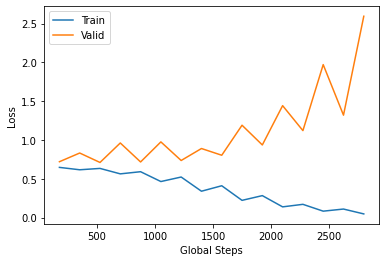

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():           
      for (labels, (text, text_len)),_ in test_loader:           
        labels = labels.to(device)
        text = text.to(device)
        text_len = text_len.to(device)  
            
        output = model(text, text_len)

        output = (output > threshold).int()
        y_pred.extend(output.tolist())
        y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['SPOILER', 'NON-SPOILER'])
    ax.yaxis.set_ticklabels(['SPOILER', 'NON-SPOILER'])
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print("AUC=", metrics.auc(fpr, tpr))
    


Model loaded from <== /content/drive/My Drive/DL/DL_Final_Project/destination_lstm/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.5631    0.7873    0.6566      1020
           0     0.5625    0.3093    0.3991       902

    accuracy                         0.5630      1922
   macro avg     0.5628    0.5483    0.5279      1922
weighted avg     0.5628    0.5630    0.5358      1922

AUC= 0.5482837702708578


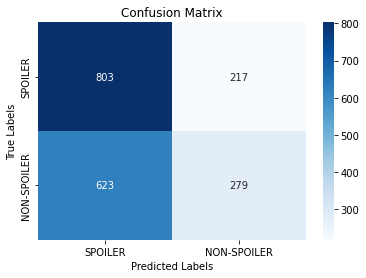

In [ ]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)